In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import tifffile as tf
from scipy import ndimage, stats
import utils

import matplotlib as mpl
from importlib import reload

In [2]:
nuccutoff = 1
wong = ['#d81b60', '#b5b5b5', '#6b6b6b', '#000000']
marker = ['D', '8', 's', '^', 'v', 'P', 'X', '*']
color = ['#c44601', '#054fb9', '#5ba300', '#8babf1', '#e6308a', '#5928ed']
cmap = ['Blues_r', 'Greens_r', 'BuPu_r', 'Oranges_r', 'RdPu_r', 'YlOrBr_r', 'gray', 'gist_gray', 'Wistia']
fs = 15
pvaltol = 0.025
columns = ['ndimage_ID', 'nuc_ID', 'perc_inside', 'N_inside', 
           'pval_up', 'lim_up', 'pval_down', 'lim_down',
           'N_lesser_lim_up', 'N_greater_lim_down', 'r_lesser_lim_up', 'r_greater_lim_down']
dfastype = {'ndimage_ID':int, 'nuc_ID':int, 'N_inside':int, 'lim_up':int, 'lim_down':int,
            'N_lesser_lim_up':int, 'N_greater_lim_down':int}
pvaldirs = ['pval_up', 'pval_down']


sample = 'D2'

fsrc = os.pardir + os.sep + 'Bacteria Info for Erik' + os.sep
csrc = os.pardir + os.sep + 'data' + os.sep + sample + '_data' + os.sep
wsrc = os.pardir + os.sep + 'cell_dams' + os.sep
nsrc = os.pardir + os.sep + 'nuclear_mask' + os.sep
ksrc = os.pardir + os.sep + 'kde' + os.sep + sample + os.sep
dst = fsrc

wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv', index_col = 0)
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')

# Get the list of the infected cell IDs and match them to our internal IDs
Cells = pd.read_excel(fsrc + 'Infected Cells w. Nuc.xlsx').values.squeeze()
cells = np.zeros_like(Cells)
for i in range(len(Cells)):
    cells[i] = metacell[metacell['orig_cellID'] == Cells[i]].index[0]

# Get labels for all the nuclei
nuclei = tf.imread(nsrc + sample + '_EDT.tif') < nuccutoff
lnuc, nnuc = ndimage.label(nuclei, ndimage.generate_binary_structure(2,1))
nuc_area, _ = np.histogram(lnuc, bins=np.arange(nnuc + 2))
nuc_area[0] = 0 #ignore the non-nuclear area
print('Detected',nnuc,'nuclei')

foo = [ wong[-1], wong[-2] ] + np.repeat(wong[1], nnuc).tolist() + ['#f0f0f0']
cellular_cmap = mpl.colors.ListedColormap(foo)

# Load all the mRNA locations
filename = csrc + '32771-slide1_' + sample + '_results.txt'
tlocs = pd.read_csv(filename, header=None, sep='\t').drop(columns=[4])
tlocs.columns = ['X', 'Y', 'Z', 'T']
transcriptomes, invidx = np.unique(tlocs['T'], return_index = False, return_inverse=True) 
tlocs = tlocs[['X','Y','Z']]

# Mark all the transcripts temporarily as located in the cytosol
tlocs['L'] = 'c'
print('\nFound data for', len(transcriptomes), 'transcriptomes')
zmax = tlocs['Z'].max()
zmin = tlocs['Z'].min()
bins = np.arange(zmin, zmax+1, 1)
hparams = {'bins':bins, 'alpha':0.5, 'density':True, 'orientation':'horizontal', 'zorder':2}

# Split the location coordinates based on gene
translocs = [None for i in range(len(transcriptomes))]
for tidx in range(len(transcriptomes)):
    translocs[tidx] = tlocs.loc[invidx == tidx].copy()
    translocs[tidx]['tidx'] = tidx

# Consider the first 10 genes aside (bacterial genes)
# Keep track of the cell ID and nucleus ID they are located in
tbac = pd.concat(translocs[:10], ignore_index=True)
tbac['cidx'] = label[ tbac['Y'], tbac['X'] ]
tbac['nidx'] =  lnuc[ tbac['Y'], tbac['X'] ]

# Split the list into bacterial genes that share X,Y coordinates with nuclei
# And those bacterial genes that do not
nuct = tbac.loc[ nuclei[ tbac['Y'], tbac['X'] ] ]
cytt = tbac.loc[~nuclei[ tbac['Y'], tbac['X'] ] ]
print('\nNo. of bacterial transcripts putatively in the nuclei:\t', len(nuct))
print('No. of bacterial transcripts in the cytosol:\t', len(cytt))

# For the rest of genes, keep track of their cell ID and nuclear ID location
tgen = pd.concat(translocs[10:], ignore_index=True)
tgen['cidx'] = label[ tgen['Y'], tgen['X'] ]
tgen['nidx'] =  lnuc[ tgen['Y'], tgen['X'] ]

# Grab the GLYMA mRNAs that share their X,Y coordinates with nuclei
nucg = tgen.loc[ nuclei[ tgen['Y'] , tgen['X'] ] ]
print('No. of GLYMA transcripts (all locations):\t', len(tgen))
print('---\nNo. of GLYMA transcripts putatively in the nuclei:\t', len(nucg))

Detected 1365 nuclei

Found data for 97 transcriptomes
(24596, 7) (1963314, 7)
(1842474, 7) (102868, 7)


# Doing one example

For one infected cell with nucleus (ID 169), we look at the bacterial transcripts `nbac` that share their X,Y-coordinates with the nucleus. We compare the distribution of their Z-coordinates with the Z-coordinates of the bacterial transcripts located in the cytosol.

In principle, bacterial transcripts should not be part of the nucleus and we should observe a Z-coordinate at which their distributions (putatively nuclear vs cytosolic) differ the most. This point is estimated with a Kolmogorov-Smirnov test.

In [76]:
cidx = 169

cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc)
s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]

nidxs, ncts = np.unique(lnuc[s_][ (lnuc[s_] > 0) & (label[s_] == cidx) ], return_counts=True)
perc_nuc_inside = ncts/nuc_area[nidxs]
print('Nuclear IDs:\t', nidxs, '\nNo. of pixels corresponding to nuclei IDs:\t', ncts, sep='')
print('% of nucleus inside cell:\t', perc_nuc_inside)

cx,cy,cz = cytt.loc[ cytt['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
nbac = [ nuct.loc[ (nuct['cidx'] == cidx) & (nuct['nidx'] == nidx) , ['X', 'Y', 'Z'] ].values.T for nidx in nidxs ]
bar = np.array([ x.shape[1] for x in nbac ])
print('---\nNo. of bacterial transcripts that are putatively nuclear (one count per nuclear ID):\t', bar)

Nuclear IDs:	[77]
No. of pixels corresponding to nuclei IDs:	[3144]
% of nucleus inside cell:	 [1.]
---
No. of bacterial transcripts that are putatively nuclear (one count per nuclear ID):	 [73]


In [77]:
nuc_lims = [None for _ in range(len(bar))]
for k in np.nonzero( bar > 9 )[0]:
    NZ = nbac[k][2]
    ksless = stats.ks_2samp(NZ,cz,'less', method='asymp')
    ksgreater = stats.ks_2samp(NZ,cz,'greater', method='asymp')    
    foo = [cidx, nidxs[k], perc_nuc_inside[k], len(nbac[k][2]),
           ksless.pvalue, ksless.statistic_location, 
           ksgreater.pvalue, ksgreater.statistic_location, 
           np.sum(NZ < ksless.statistic_location), np.sum(NZ > ksgreater.statistic_location),
           np.sum(NZ < ksless.statistic_location)/len(NZ), np.sum(NZ > ksgreater.statistic_location)/len(NZ)
    ]
    nuc_lims[k] = foo
for k in np.nonzero( bar <= 9 )[0]:        
    foo = [cidx, nidxs[k], perc_nuc_inside[k], len(nbac[k][2]), 2 , zmax + 1,  2, zmin - 1, 0, 0, 0, 0 ]
    nuc_lims[k] = foo

print('SUMMARY\n========')
for foo in nuc_lims:
    for i in range(len(columns)):
        print(columns[i], ':\t', foo[i])
    print('-------------------------------------')

SUMMARY
ndimage_ID :	 169
nuc_ID :	 77
perc_inside :	 1.0
N_inside :	 73
pval_up :	 1.7524996710049144e-17
lim_up :	 27
pval_down :	 0.9144617109736105
lim_down :	 39
N_lesser_lim_up :	 1
N_greater_lim_down :	 0
r_lesser_lim_up :	 0.0136986301369863
r_greater_lim_down :	 0.0
-------------------------------------


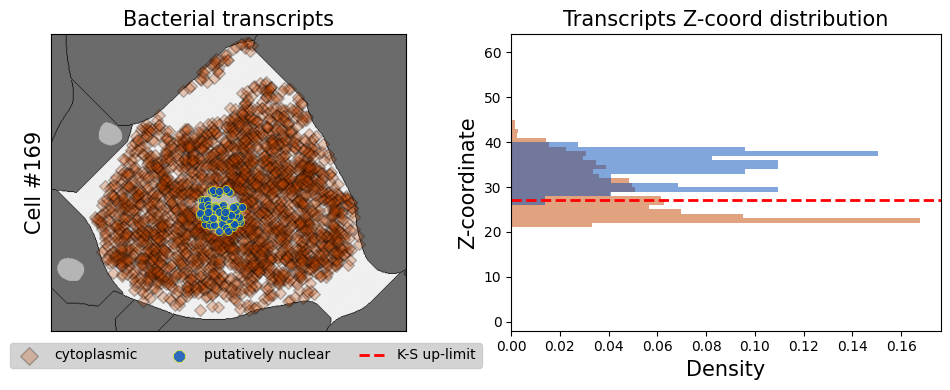

In [78]:
kw = dict(ec='yellow', alpha=0.8, zorder=3, linewidth=0.5)
fig, ax = plt.subplots( 1, 2 , figsize=(10, 4), sharex=False, sharey=False)
ax = np.atleast_1d(ax).ravel(); j = 0

ax[j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2, zorder=1);
ax[j].set_facecolor('#808080')
ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax[j].set_ylabel('Cell #{}'.format(cidx), fontsize=fs)
ax[j].set_title('Bacterial transcripts', fontsize=fs)
ax[j].scatter(cx,cy, c=color[0], marker=marker[0], edgecolor='k', alpha=0.25, zorder=2, label='cytoplasmic')
ax[1].hist(cz, color=color[0], **hparams)
for k in np.nonzero( bar > 9 )[0]:
    ax[0].scatter(nbac[k][0],nbac[k][1], c=color[1], marker=marker[1], label = 'putatively nuclear', **kw)
    ax[1].hist(nbac[k][2], color=color[1], **hparams)
    if nuc_lims[k][4] < pvaltol:
        ax[1].axhline(nuc_lims[k][5], c='r', lw=2, ls='dashed', label='K-S up-limit')
    if nuc_lims[k][6] < pvaltol:
        ax[1].axhline(nuc_lims[k][7], c='r', lw=2, ls='dashed', label='K-S down-limit')
j = 1
ax[j].set_title('Transcripts Z-coord distribution'.format(cidx), fontsize=fs)
ax[j].set_ylabel('Z-coordinate', fontsize=fs)
ax[j].set_xlabel('Density', fontsize=fs)
fig.legend(bbox_to_anchor=(0.03, 0.05), loc='lower left', ncols=3, framealpha=1, facecolor='lightgray', markerscale=1.5)
fig.tight_layout();

### Put it in a loop

Now repeat the computations for all* cells. 

*Limited to cells with nuclei at least 100 pixels in size and 9 bacterial transcripts sharing nuclear X,Y coordinates.

In [80]:
metanuc = dict()
filename = dst + 'BAC_nuclear_localization_estimates_v2.csv'

if not os.path.isfile(filename):
    nuc_lims = []
    
    for cidx in range(1, len(metacell)+1):
            
        if metacell.loc[cidx, 'nuclei_area'] > 100:
        
            cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc)
            s_= np.s_[ cextent[2]:cextent[3], cextent[0]:cextent[1] ]
                
            nidxs, ncts = np.unique(lnuc[s_][ (lnuc[s_] > 0) & (label[s_] == cidx) ], return_counts=True)
            perc_nuc_inside = ncts/nuc_area[nidxs]
            cx,cy,cz = cytt.loc[ cytt['cidx'] == cidx , ['X', 'Y', 'Z'] ].values.T
            nbac = [ nuct.loc[ (nuct['cidx'] == cidx) & (nuct['nidx'] == nidx) , ['X', 'Y', 'Z'] ].values.T for nidx in nidxs ]
            metanuc[cidx] = [ nidxs, ncts ]
            bar = np.array([ x.shape[1] for x in nbac ])
            
            for k in np.nonzero( bar > 9 )[0]:
                NZ = nbac[k][2]
                ksless = stats.ks_2samp(NZ,cz,'less', method='asymp')
                ksgreater = stats.ks_2samp(NZ,cz,'greater', method='asymp') 
               
                foo = [cidx, nidxs[k], perc_nuc_inside[k], len(nbac[k][2]),
                       ksless.pvalue, ksless.statistic_location, 
                       ksgreater.pvalue, ksgreater.statistic_location, 
                       np.sum(NZ < ksless.statistic_location), np.sum(NZ > ksgreater.statistic_location),
                       np.sum(NZ < ksless.statistic_location)/len(NZ), np.sum(NZ > ksgreater.statistic_location)/len(NZ)
                ]    
                nuc_lims.append(foo)

            for k in np.nonzero( bar <= 9 )[0]:   
                foo = [cidx, nidxs[k], perc_nuc_inside[k], len(nbac[k][2]), 2 , zmax + 1,  2, zmin - 1, 0, 0, 0, 0 ]
                nuc_lims.append(foo)
    
    df = pd.DataFrame(np.array(nuc_lims), columns=columns).astype(dfastype)
    df.to_csv(filename, index=False)
    
bacs = pd.read_csv(filename)
print(bacs.shape)
bacs.head()

(1719, 12)


,ndimage_ID,nuc_ID,perc_inside,N_inside,pval_up,lim_up,pval_down,lim_down,N_lesser_lim_up,N_greater_lim_down,r_lesser_lim_up,r_greater_lim_down
0,1,1,0.011579,0,2.0,62,2.0,0,0,0,0.0,0.0
1,1,3,1.000000,0,2.0,62,2.0,0,0,0,0.0,0.0
2,1,4,0.431034,0,2.0,62,2.0,0,0,0,0.0,0.0
3,1,9,1.000000,0,2.0,62,2.0,0,0,0,0.0,0.0
4,1,15,1.000000,0,2.0,62,2.0,0,0,0,0.0,0.0


# Summarize the above table

- Keep only the nuclear limits that are significant (K-S pvalue < 0.025)
- If K-S pvalue is large, assume that the limit is either Zmin or Zmax accordingly

In [81]:
filename = ksrc + sample + '_nuclei_limits_v2.csv'
if not os.path.isfile(filename):
    
    cell_nuc = bacs.loc[:, ['ndimage_ID','nuc_ID', 'perc_inside']].drop_duplicates()    
    N_bot = np.zeros(len(cell_nuc), dtype = int); 
    N_top = N_bot.copy()
    N_inside = N_bot.copy()
    
    P_top = np.zeros(len(cell_nuc)); 
    P_bot = P_top.copy()
    
    for i in range(len(cell_nuc)):
        n_bot, n_top = zmin-1, zmax+1
        p_bot, p_top = 0,0
        cidx, nidx = cell_nuc.iloc[i, :2].values
        
        nuc_lims = bacs.iloc[i]
        N_inside[i] = nuc_lims['N_inside']
        
        if nuc_lims['pval_up'] < pvaltol:
            n_top = nuc_lims['lim_up']
            p_top = nuc_lims['pval_up']
        
        if nuc_lims['pval_down'] < pvaltol:
            n_bot = nuc_lims['lim_down']
            p_bot = nuc_lims['pval_down']
        
        N_bot[i] = n_bot; N_top[i] = n_top
        P_bot[i] = p_bot; P_top[i] = p_top
    
    cell_nuc['N_inside'] = N_inside
    cell_nuc['n_bot'] = N_bot
    cell_nuc['n_top'] = N_top
    cell_nuc['p_bot'] = P_bot
    cell_nuc['p_top'] = P_top
    
    print(filename)
    cell_nuc.to_csv(filename, index=False)

cell_nuc = pd.read_csv(filename)
print(cell_nuc.shape)
cell_nuc.head()

(1719, 8)


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
0,1,1,0.011579,0,0,62,0.0,0.0
1,1,3,1.000000,0,0,62,0.0,0.0
2,1,4,0.431034,0,0,62,0.0,0.0
3,1,9,1.000000,0,0,62,0.0,0.0
4,1,15,1.000000,0,0,62,0.0,0.0


Keep only the calculations for infected cells that have exactly one, well-defined nucleus

In [86]:
focus = np.intersect1d(cells, metacell[metacell['number_nuclei'] <= 1].index)
keep_ = []
for i in range(len(focus)):
    cidx = focus[i]
    foo = cell_nuc.loc[cell_nuc['ndimage_ID'] == cidx, 'perc_inside']
    if len(foo) > 0:
        foo = foo.argmax()
        keep_.append(cell_nuc.loc[cell_nuc['ndimage_ID'] == cidx].index[foo])

df = cell_nuc.loc[keep_]
df = df[df['perc_inside'] > 0.5]
print(df.shape)
df.head()

(323, 8)


,ndimage_ID,nuc_ID,perc_inside,N_inside,n_bot,n_top,p_bot,p_top
133,169,77,1.0,73,0,27,0.000000e+00,1.752500e-17
185,233,123,1.0,18,0,27,0.000000e+00,8.125130e-05
187,235,121,1.0,122,27,62,8.499143e-15,0.000000e+00
188,236,126,1.0,120,27,62,2.682950e-08,0.000000e+00
221,276,153,1.0,112,27,62,1.303773e-13,0.000000e+00


# Determine whether GLYMA transcripts are really nuclear or not

Now that we have estimated the Z-location of the nucleus (by comparing the distribution of bacterial transcripts), we determine whether GLYMA transcripts that share X,Y-coordinates with the nucleus are actually nuclear or not.

In [92]:
for tidx in range(10, len(transcriptomes)):
    # Fix a gene
    # Get the transcripts that are in X,Y nuclear coordinates
    
    nuct = translocs[tidx].loc[ nuclei[ translocs[tidx]['Y'], translocs[tidx]['X'] ] ].copy()
    nuct['cidx'] = label[ nuct['Y'], nuct['X'] ]
    nuct['nidx'] =  lnuc[ nuct['Y'], nuct['X'] ]
    
    for i in range(len(cell_nuc)):

        # Get the transcripts specific for a cell and nucleus
        cidx, nidx, n_bot, n_top = cell_nuc.iloc[i][ ['ndimage_ID', 'nuc_ID', 'n_bot', 'n_top']].values.astype(int)
        tnz = nuct.loc[ (nuct['cidx'] == cidx) & (nuct['nidx'] == nidx) , 'Z']
        
        if len(tnz) > 0:
            nz = tnz.values
            localization = np.where( (nz >= n_bot) & (nz <= n_top), 'n', 'c' )
            translocs[tidx].loc[tnz.index, 'L'] = localization

In [93]:
TT = np.array([ len(translocs[tidx]) for tidx in range(10, len(transcriptomes)) ] )
NN = np.array([ len(translocs[tidx][translocs[tidx]['L'] == 'n']) for tidx in range(10,len(transcriptomes)) ])
NN

array([  208,    51,    88,    28,   135,    21,  1266,    17,     3,
           1,    32,     0,    14,     9,    85,   781, 10449,   221,
         828,   242,    22,   204,    18,    44,   838,   670,     0,
           0,    19,    15,    21,    50,     9,   159,     3,     0,
           0,   391,   469,     9,    42,     8,    27,    49,    22,
          23,   305,   918,   146,   112,     5,     2,  1934,     1,
           0,     3,   191,     5,     0,    20,    37,    19,     3,
           2,  1389,   306,     2,  1871,   174,   131,    11,     0,
          24,     9,   164, 59968,    24,     0,   156,    45,     1,
          15,   459,     4,   717,   183,    71])

Save results

In [ ]:
for tidx in range(len(transcriptomes)):
    filename = dst + transcriptomes[tidx] + '_v2.txt'
    print(filename)
    foo = translocs[tidx].copy()
    #foo['ID'] = transcriptomes[tidx]
    foo.to_csv(filename, sep='\t', index=False)

# Representative plots (ignore)

In [88]:
xlabel = ['X-coordinate', 'Density', 'X-coordinate']
ylabel = ['Y-coordinate', 'Z-coordinate', '']
    
for i in [235,305,325,432,585,625,168,232,300,234,275,292,289,293,302]:
    cidx = metacell.iloc[i].name
    cell, cextent = utils.get_cell_img(cidx, metacell, label, lnuc, nnuc, PP=5)
    s_= np.s_[cextent[2]:cextent[3], cextent[0]:cextent[1]]
    
    cx,cy,cz = cytt.loc[label[ cytt['Y'], cytt['X'] ] == cidx, ['X','Y','Z']].values.T
    NX,NY,NZ = [ [None for _ in range(len(cell_nucs[i][0])) ] for _ in range(3)]
    for k in range(len(cell_nucs[i][0])):
        NX[k],NY[k],NZ[k] = nuct.loc[(label[nuct['Y'], nuct['X']] == cidx) & (lnuc[nuct['Y'], nuct['X']] == cell_nucs[i][0,k]), ['X','Y','Z']].values.T
        
    fig, ax = plt.subplots( 1, 3, figsize=(12, 5), sharex=False, sharey=False)
    ax = np.atleast_1d(ax).ravel(); j = 0
    
    ax[j].imshow(cell+1, cmap=cellular_cmap, origin='lower', extent=cextent, vmin=0, vmax=nnuc+2, zorder=1);
    ax[j].scatter(cx, cy, c=color[0], marker=marker[0], edgecolor='gray', alpha=0.25, zorder=2, linewidth=0.25)
    ax[2].scatter(cx, cz, c=color[0], marker=marker[0], edgecolor='gray', alpha=0.25, zorder=2, linewidth=0.25)
    
    ax[j].set_facecolor(wong[2])
    ax[j].set_aspect('equal', 'datalim')
    
    j = 1
    axh, ll = [], []
    ax[j].hist(cz, color=color[0], label='(X,Y) shared w/ cytoplasm', **hparams)
    for k in range(len(NZ)):
        df = cell_nuc.loc[(cell_nuc['ndimage_ID'] == cidx) & (cell_nuc['nuc_ID'] == cell_nucs[i][0,k])].iloc[0]
        foo = np.nonzero(lnuc[s_] == cell_nucs[i][0,k])[1] + cextent[0]
        n_bot, n_top, p_bot, p_top = df.loc[['n_bot', 'n_top', 'p_bot', 'p_top']].values
        if(len(NZ[k]) > 4):
            nx = NX[k]; ny = NY[k]; nz = NZ[k]
            ax[1].hist(nz, color=color[k+2], label='(X,Y) shared w/ nucleus'.format(k+1), **hparams)
            ax[0].scatter(nx, ny, c=color[k+2], marker=marker[k+2], alpha=0.25, zorder=3, linewidth=0.5, edgecolor='forestgreen')
            ax[2].scatter(nx, nz, c=color[k+2], marker=marker[k+2], alpha=1, zorder=3, linewidth=0.1, edgecolor='forestgreen')          
            if p_top > 0:
                ll.append('N$_{{\\mathregular{top}}}$ [p$_{{\\mathregular{val}}}$' + '$< 10^{{{}}}$]'.format(int(np.ceil(np.log10(p_top)))))
                axh.append(None)
                axh[-1] = ax[j].axhline(n_top, c=color[k+2], ls='--', lw=3, zorder=3)
                ax[2].axhline(n_top, c=color[k+2], ls='--', lw=3, zorder=5)
            
            if p_bot > 0:
                ll.append('N$_{{\\mathregular{bottom}}}$ [p$_{{\\mathregular{val}}}$' + '$< 10^{{{}}}$]'.format(int(np.ceil(np.log10(p_bot)))))
                axh.append(None)
                axh[-1] = ax[j].axhline(n_bot, c=color[k+1], ls='--', lw=3, zorder=3)
                ax[2].axhline(n_bot, c=color[k+1], ls='--', lw=3, zorder=5)
    
            if n_top > n_bot:        
                ax[2].fill_between([foo.min(), foo.max()], n_top, n_bot, color='#252525', alpha=0.7, zorder=4, label='hypothesized nucleus')
            else:
                ax[2].fill_between([foo.min(), foo.max()], zmin , n_top, color='#252525', alpha=0.7, zorder=4, label='hypothesized nucleus')
                ax[2].fill_between([foo.min(), foo.max()], zmax , n_bot, color='#252525', alpha=0.7, zorder=4)
        else:
            ax[2].fill_between([foo.min(), foo.max()], zmax, zmin, color='#252525', alpha=0.7, zorder=4, label='hypothesized nucleus')
    if len(ll) > 0:    
        ax[j].legend(axh, ll, fontsize=0.92*fs, loc='upper right', ncols=1);
    
    h, l = ax[2].get_legend_handles_labels()
    ax[2].legend(h[:1], l[:1], fontsize=fs, loc='upper right')
    for j in [1,2]:
        ax[j].set_ylim(zmin,zmax)
        ax[j].set_facecolor('snow')
    
    titles = ['Cell #{}'.format(metacell.loc[cidx, 'orig_cellID'])] + 2*['Bacterial transcripts']
    for j in range(len(ax)):
        ax[j].set_title(titles[j], fontsize=fs+5)
        ax[j].set_xlabel(xlabel[j], fontsize=fs)
        ax[j].set_ylabel(ylabel[j], fontsize=fs)
        ax[j].tick_params(labelsize=fs)#ax[j].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    
    h, l = ax[1].get_legend_handles_labels()
    fig.legend(h, l, fontsize=0.92*fs, loc='lower center', ncols=1, handletextpad=0, borderpad=0.25,
               bbox_to_anchor=(0.535 , 0.14), framealpha=1, facecolor='snow');
    fig.tight_layout();
    
    filename = dst + 'cell_nucleus_{}.'.format(metacell.loc[cidx, 'orig_cellID'])
    print(i, cidx, filename, sep='\t')
    plt.savefig(filename + 'pdf', format='pdf', bbox_inches='tight', dpi=96)
    plt.close()

NameError: name 'cell_nucs' is not defined